# 动手实现胶囊网络

## 前言

2017年，Hinton团队提出胶囊网络，首次将标量型网络扩展到矢量。本着learning by doing的态度，我尝试对原论文进行复现，因此这里不会对其原论文原理和思想有太多解释。尽可能保证工程性和完整性，并在实现过程中不断总结和反思。实现过程中也许会有一些bug，欢迎交流和提交issue~

**Author**: QiangZiBro   
**Github**: https://github/QiangZiBro


## 1.1 引入必备的包
本文依赖第三方框架pytorch，实验使用1.2，基本来说各个版本都可以用。

In [55]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torchvision.utils import save_image

## 1.2 超参数定义

In [56]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 5
batch_size = 64
learning_rate = 1e-3

## 1.3 数据加载

In [57]:
# MNIST dataset
root="/home/qiangzibro/2TB1/"
train_dataset = torchvision.datasets.MNIST(root=root,
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root=root,
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

label is 2


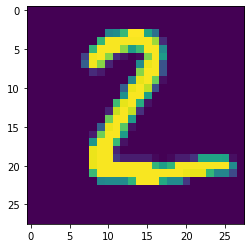

In [58]:
def show_img(data_tuple):
    img, label = data_tuple
    img = img.squeeze()
    plt.imshow(img)
    print(f"label is {label}")
    
show_img(test_dataset[1])

## 1.4 胶囊网络的压缩函数与动态路由算法
胶囊网络由三层组成：卷积层，初级胶囊层，卷积胶囊层，其中卷积胶囊层使用了动态路由算法。我们来一一实现这些功能。
首先实现两个函数，压缩函数与动态路由函数

In [60]:
def squash(x):
    """
    Args:
        x: (B, 10, 16)
    Return:
        squashed x (B, 10, 16)
    """
    L = torch.norm(x, dim=2, keepdim=True) #(B, 10, 1)
    L_square = L**2 #(B, 10, 1)
    c = (L_square)/(1+L_square)/L #(B, 10, 1)
    
    s = c*x #(B, 10, 16)
    s[s==np.nan] = 0
    return s

x = torch.rand(1,10,16)
squash(x).shape

torch.Size([1, 10, 16])

动态路由算法相当于一个聚类过程，将底层的若干个向量以迭代的路由方法，选取若干具有代表性的胶囊。
- 输入 (B, 10, 32x6x6, 16)
- 输出 (B, 10, 16)

要注意的细节
- b的维度是多少？ b是有batchsize的，我最开是设置的是没有batchsize，效果不太好。

In [61]:
def dynamic_routing(x, iterations=3):
    """
    Args:
        x: u_hat,  (B, 10, 32x6x6, 16, 1)
        
    Return:
        v: next layer output (B, 10, 16)
    """
    N = 32*6*6 # previous layer
    N1 = 10 # next layer
    B = x.shape[0]
    
    b = torch.zeros(B,N1,N,1, 1).to(x.device)
    for _ in range(iterations):        
        # probability of each vector to be distributed is 1
        # (B,10,32*6*6,1, 1)
        c = F.softmax(b, dim=1)  
 
        # (B,10,16)
        s = torch.sum(x.matmul(c), dim=2).squeeze(-1)
     
        # (B,10,16)
        v = squash(s)

        # (B,10,32*6*6,1,1)
        b = b + v[:,:,None,None,:].matmul(x)

        
    return v

x = torch.rand(1,10,32*6*6,16, 1)
dynamic_routing(x).shape

torch.Size([1, 10, 16])

## 1.5 初级胶囊层
在实现初级胶囊层时，我们要了解一些细节，比如
- 怎样表示一个胶囊？ 每个像素点上一个1x8的向量
- 怎样计算出初级胶囊？使用32组卷积核，每组输出8个通道
- 怎样在程序里存这些胶囊？我的做法是将所有的胶囊放在一列，换句话说，放在一个`(B, 32*6*6, 8)`的矩阵里面

In [62]:
class PrimaryCapsuleLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.primary_capsule_layer = \
            nn.ModuleList([nn.Conv2d(256,8,9, stride=2) for _ in range(32)])
        
    def forward(self, x):
        """ Produce primary capsules
        
        Args:
            x: features with (B, 256, 20, 20)
            
        Return:
            vectors (B, 32*6*6, 8)
        """
        capsules = [conv(x) for conv in self.primary_capsule_layer]  # [[B, 8, 6, 6] * 32] 
        capsules_reshaped = [c.reshape(-1,8,6*6) for c in capsules]  # [[B, 8, 36] * 32] 
        s = torch.cat(capsules_reshaped, dim=-1).permute(0, 2, 1)  # (B, 32*6*6, 8)
        return squash(s)

    

# 测试单元
def test_for_primary_capsule_layer():
    input = torch.rand(1,256,20,20)
    layer = PrimaryCapsuleLayer()
    assert layer(input).shape == (1,32*6*6, 8)
test_for_primary_capsule_layer()

## 1.6 卷积胶囊层
在实现卷积胶囊层时，我们要了解一些细节，比如
- 高维矩阵相乘怎么进行计算？
  比如对(B, 32x6x6, 8)大小的向量矩阵，通过权重矩阵，得到输出(B,10, 32x6x6,16)的矩阵，通过下面高维矩阵相乘方式推出$o=Wx$
  - W `(1, 10, 32x6x6, 16, 8)`
  - x `(B, 1,  32x6x6, 8,  1) `  
  - o `(B, 10, 32x6x6, 16, 1)`
  
  上面两个矩阵相乘看起来有点复杂，怎么思考呢？多维矩阵的相乘可以看作最后两个维度作矩阵乘法，两个维度我们肯定很清楚，维度(a,b)和(b,c)两个矩阵相乘就是(a,c)。其他维度要么进行广播机制，要么不变。所以，从上面的维度，可以知道，前两个维度实行广播机制，第三个不变，最后两个维度的乘法也就是(16,8)和(8,1)的向量相乘，完成了变换。因此，就有了下面的例子
  ```python
    B = 1
    x = torch.rand(B,32*6*6,8)
    x = x[:,None,...,None]

    w = torch.rand(1,10,32*6*6,16,8)
    w.matmul(x).shape
    # torch.Size([1, 10, 1152, 16, 1])
    ```

In [63]:
class CapsLayer(nn.Module):
    def __init__(self,nclasses=10, out_channels_dim=16):
        super().__init__()
        self.W = nn.Parameter(1e-3 * torch.randn(1,nclasses,32*6*6,out_channels_dim,8))
        
    def forward(self, x):
        """Predict and routing
        
        Args:
            x: Input vectors, (B, 32*6*6, 8)
            
        Return:
            class capsules, (B, 10, 16)
        """
        x = x[:,None,...,None]
        u_hat = self.W.matmul(x)  # (B, 10, 32x6x6, 16, 1)
        assert u_hat.shape[1:] == (10, 32*6*6, 16, 1)
        class_capsules = dynamic_routing(u_hat)
        return class_capsules
    
    
def test_for_caps_layer():
    input = torch.rand(1,32*6*6,8)
    layer = CapsLayer()
    assert layer(input).shape == (1,10,16)
test_for_caps_layer()

## 1.7 胶囊网络
实现了前面必须的几层，相信胶囊网络也是非常好搭了。我们定义的胶囊网络最后输出为10个分类向量

In [64]:
class CapsNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Conv2d(1,256,9)
        self.primary_layer = PrimaryCapsuleLayer()
        self.caps_layer = CapsLayer(nclasses=10, out_channels_dim=16)
        
    def forward(self, x):
        """
        Args:
            x : Input img, (B, 1, 28, 28)
        
        Return:
            the class capsules, each capsule is a 16 dimension vector
        """
        x = self.conv_layer(x)  # (B, 256, 20, 20)
        x = self.primary_layer(x)  # (B, 32*6*6, 8)
        x = self.caps_layer(x)  # (B, 10, 16)
        return x
    
def test_for_caps_net():
    input = torch.rand(1,1,28,28)
    model = CapsNet()
    assert model(input).shape == (1,10,16)
    
test_for_caps_net()

# 实验1 训练一个分类的胶囊网络

## 实现损失
现在我们来到第一个实验，训练一个分类网络。首先了解原文提到的损失

$$
L_{k}=T_{k} \max \left(0, m^{+}-\left\|\mathbf{v}_{k}\right\|\right)^{2}+\lambda\left(1-T_{k}\right) \max \left(0,\left\|\mathbf{v}_{k}\right\|-m^{-}\right)^{2}
$$

这其中$\left\|\mathbf{v}_{k}\right\|$就是胶囊网络最后输出来的分类胶囊，k表示第k个。这个式子可以理解为一个分段函数

\begin{equation}
L_{k}=\left\{
\begin{aligned}
\max \left(0, m^{+}-\left\|\mathbf{v}_{k}\right\|\right)^{2}& & {第k个胶囊正确分类} \\
\lambda \max \left(0,\left\|\mathbf{v}_{k}\right\|-m^{-}\right)^{2} & & {第k个胶囊错误分类}
\end{aligned}
\right.
\end{equation}

其中$m^{+}=0.9,m^{-}=0.1, \lambda=0.5$，也就是说，分类胶囊是概率为0.9以上且分类正确的，以及概率为0.1且错误的，我们都是为是”好“的，因此训练时我们采样梯度下降到方式往这个方向靠拢。   
因此，我们首先需要自定义一个损失。在pytorch里面，损失定义很简单

一些细节
- 使用onehot向量T和预测胶囊模长相乘来选取正确预测的值，(1-T)和预测胶囊模长相乘来选取错误预测的值

In [65]:
#TODO: test it!
def margin_loss(y, y_hat):
    """
    Args:
        y: ground truth labels (B)
        y_hat: class capsules with (B, 10, 16)
        
    Return
        the margin loss
    """
    _lambda = 0.5
    m_plus = 0.9
    m_minus = 0.1
    nclasses = 10
    
    y_norm = y_hat.norm(dim=-1) # (B,10)
    T = F.one_hot(y, nclasses) # use it as index for right class (B,10)
    T = T.float()

    right = torch.max(torch.zeros_like(y_norm), m_plus-y_norm*T)
    right = right**2
    wrong = torch.max(torch.zeros_like(y_norm), y_norm*(1-T)-m_minus)
    wrong = _lambda*wrong**2
    return torch.sum(right+wrong)

def test_margin_loss():
    y = torch.randint(0,10,(20,))
    y_hat = torch.rand(20,10,16)
    print(margin_loss(y,y_hat).item())

In [259]:
import time

def train(net, epochs, dataloader,reconstruction=False, report=30):
    """ 
    global variable:
        - train_loader
    """
    net.train()

    optimizer = torch.optim.Adam(net.parameters())

    train_history = []
    for epoch in range(epochs):
        t0 = time.time()
        
        epoch_loss = torch.tensor(0.)
        for batch, (X_batch, y_batch) in enumerate(dataloader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            if reconstruction:
                y_hat_param = net(X_batch, y_batch)
                loss = total_loss(X_batch, y_batch, y_hat_param)
            else:
                y_hat = net(X_batch)
                loss = margin_loss(y_batch, y_hat)
            epoch_loss += loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_history.append(epoch_loss.item())
        print(f"Epoch {epoch+1} loss is {epoch_loss}")
    return train_history

In [66]:
# Start training
torch.autograd.set_detect_anomaly(True)

encoder = CapsNet().to(device)
train(encoder, 5, train_loader, margin_loss, report=460)

Epoch 1
	Batch 459
		Training Loss: 217069.953
		Time: 168.944s
	Batch 919
		Training Loss: 215645.812
		Time: 168.651s
Epoch 2
	Batch 459
		Training Loss: 215400.625
		Time: 168.716s
	Batch 919
		Training Loss: 215362.047
		Time: 169.112s
Epoch 3
	Batch 459
		Training Loss: 215193.094
		Time: 167.462s
	Batch 919
		Training Loss: 215290.953
		Time: 169.099s
Epoch 4
	Batch 459
		Training Loss: 215119.266
		Time: 168.276s
	Batch 919
		Training Loss: 215151.844
		Time: 171.731s
Epoch 5
	Batch 459
		Training Loss: 215083.062
		Time: 168.992s
	Batch 919
		Training Loss: 215115.438
		Time: 173.077s


In [68]:
# Test the model
def evaluate(model, test_loader):
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            outputs = outputs.norm(dim=-1)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

acc = evaluate(encoder, test_loader)

In [73]:
print('Test Accuracy of the model on the 10000 test images: {:.2f}%'.format(100 * acc))

Test Accuracy of the model on the 10000 test images: 98.62%


有点惊喜，训练了五个epoch，效果还不错。

# 实验2 构建重建网络
## 解码器实现
除了做简单的分类外，原作者对预测正确的向量进行解码，解码到图片空间。这个过程现有的实现都是用MLP来实现的。也就是说，对一个预测正确的向量(1x16)，使用`(16 --> 28*28)`的解码网络即可，只是中间网络层数可能需要多一些。原文用了三个全连接层，[1][2]给隐层size设定都是512，1024。

这里编程的细节有
- 运用zip来迭代两个序列
- 根据list来选元素: `class_capsules[torch.arange(B), y]`，参考https://discuss.pytorch.org/t/selecting-element-on-dimension-from-list-of-indexes/36319/3
- 在训练的时候，因为前面encoder已经训练过了，我们可以冻结掉前面编码网络参数，只训练解码网络，可以进行下列操作


```python

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(encoder, True)
# 对优化器
optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, net.parameters()),
        lr=0.1
    )
```

In [253]:
class MLPDecoder(nn.Module):
    """Decode the input predicted vectors tor origin images
    
    Usage:
        decoder = MLPDecoder([512, 1024], 16, (28,28))
        reconstructed_x = decoder(selected_capsules)
    """
    def __init__(self, hidden, in_channels, out_shape):
        super().__init__()
        self.out_shape = out_shape
        h,w = out_shape
        out_channels = w*h
        self.mlp = nn.Sequential(*[
            nn.Linear(_in, _out)
            for _in,_out in zip([in_channels]+hidden, hidden+[out_channels])
        ])
        
        
    def forward(self, x):
        """
        Args:
            x: (B,16)
            
        Return:
            reconstructed images with (B,1,28,28)
        """
        B = x.shape[0]
        x = self.mlp(x)
        x = x.reshape(B, 1, *self.out_shape)
        return x
    
def test_decoder():
    decoder = MLPDecoder([512, 1024], 16, (28,28))
    x = torch.rand(5,16)
    assert decoder(x).shape == (5,1,28,28)
test_decoder()

对于自编码器的设计，我们将编解码设得灵活一点，通过构造函数传入

In [254]:
class CapsAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x, y):
        """
        Args:
            x: (B, C, H, W) (B,1,28,28)
            y: (B)
            
        Return:
            reconstructed images with (B,1,28,28)
        """
        B = x.shape[0]
        
        class_capsules = self.encoder(x)  # (B, 10, 16)
        selected_capsules = class_capsules[torch.arange(B), y] #  (B, 16)
        assert selected_capsules.shape ==  (B, 16)
        
        reconstructed_x = self.decoder(selected_capsules)
        
        
        return class_capsules,reconstructed_x

- 加上重建损失的总损失

$$
L_{total} = L_{margin} + 0.0005 \times L_{reconstruction}
$$
其中
$$
 L_{reconstruction} = ||x - \hat{x} ||^2
$$


In [265]:
def total_loss(x, y, y_hat_params, c=0.0005):
    """ marigin loss + 0.00005reconstruction loss
    
    Args:
        x: (B,C,H,W)
        y: (B,)
        y_hat_params: a tuple of (class_capsules, reconstructed_x)
    """
    class_capsules, reconstructed_x = y_hat_params
    
    return margin_loss(y, class_capsules)+c*F.mse_loss(x,reconstructed_x)

In [266]:
encoder = CapsNet()
decoder = MLPDecoder([512, 1024], 16, (28,28))
autoencoder = CapsAE(
    encoder = encoder,
    decoder = decoder
).to(device)

In [ ]:
train_loss = train(autoencoder, 5, train_loader, reconstruction=True, report=460)

## 模型评估
对自编码器，我们从两个方面来评估：
- 编码器的分类能力
- 解码器解码效果

In [261]:
acc = evaluate(encoder, test_loader)
print('Test accuracy of the model on the 10000 test images of encoder in AE: {:.2f}%'.format(100 * acc))

Test Accuracy of the model on the 10000 test images of encoder in AE: 98.80%


In [262]:
def evaluate_ae(model, test_loader, once=False):
    """ get all reconstruction results
    Args:
        model: autoencoder
        test_loader
        
    Return:
        origin images and reconstructed images (N,1,28,28)
    """
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

    with torch.no_grad():
        X_ = [] # reconstructed images
        X = [] # origin images
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            _, x_ = model(images, labels)
            X_.append(x_)
            X.append(images)
            
            if once:
                break
            
    return torch.cat(X, dim=0),torch.cat(X_, dim=0)

In [263]:
X,X_ =  evaluate_ae(autoencoder, test_loader, once=True)
X,X_ = X.cpu(),X_.cpu()

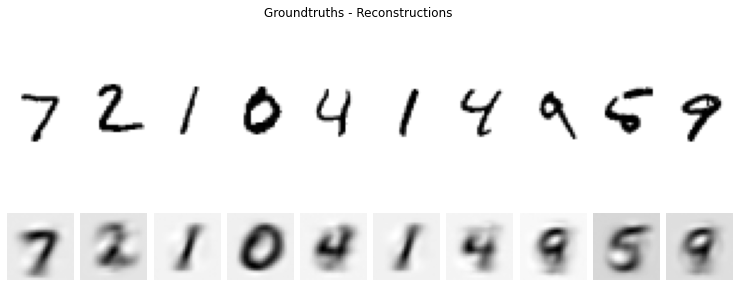

In [264]:
fg, axs = plt.subplots(nrows=2, ncols=10, gridspec_kw={'hspace': 0, 'wspace': 0.1}, figsize=(13,5))
fg.suptitle('Groundtruths - Reconstructions')

for i in range(10):
    axs[0, i].imshow(X[i].squeeze(), cmap='binary')
    axs[1, i].imshow(X_[i].squeeze(), cmap='binary')
    axs[0, i].axis('off')
    axs[1, i].axis('off')
plt.show()

## 总结
- 重建效果 不是特别好，和[1]相比有些糊，但是基本轮廓是重建出来了

# 实验3 分类胶囊的每一位代表什么？

In [ ]:
def evaluate_class_capsule(model, x, y, delta=1, dim=0, l=5):
    """ Simply adding class capsules digit from -7 to 7, to 
    see what happens about reconstruction.
    
    Args:
        model: autoencoder
        x: input image (B,1,28,28)
        y
        dim: which dim you want to research

        
    Return 
        [origin image,reconstructed_xs] [(B,1,28,28), ... ,(B,1,28,28)]
    """
    model.eval()
    B = x.shape[0]
    encoder, decoder = model.encoder, model.decoder
    
    with torch.no_grad():        
        # Auto encoder, but adding class capsules digit from -7 to 7 
        class_capsules = encoder(x)  # (B, 10, 16)
        selected_capsules = class_capsules[torch.arange(B), y] #  (B, 16)
        assert selected_capsules.shape ==  (B, 16)
        
        index = F.one_hot(torch.ones(1, dtype=torch.long)*dim, num_classes=16)
        index = index.float().to(device)
        
        shifted_capsules = [selected_capsules+i*delta*index for i in range(-l,l+1)]
        reconstructed_xs = [decoder(i) for i in shifted_capsules]
        
    reconstructed_xs.insert(0, x)
    return reconstructed_xs

In [ ]:
def research_for_class_capsule(N=2, dim=0, delta=0.5):
    """ Simply test N of first batch of test loader for dim 
    
    """
    for X,y in test_loader:
        X,y = X[0:N].to(device),y[0:N].to(device)
        result = evaluate_class_capsule(autoencoder, X, y, delta=delta, dim=dim)
        break
        
    fg, axs = plt.subplots(nrows=N, ncols=len(result), gridspec_kw={'hspace': 0, 'wspace': 0.1}, figsize=(13,5))
    fg.suptitle(f'research for capsule dim={dim}, delta={delta}')

    for i in range(N):
        for j in range(len(result)):
            axs[i, j].imshow(result[j][i].squeeze().cpu(), cmap='binary')
            axs[i, j].axis('off')
    plt.show()

In [ ]:
def research_for_class_capsule_for(i=0,  delta=0.5):
    """ Test class capsule dim usage for i th test image
    
    """
    result = []
    for X,y in test_loader:
        X,y = X[i][None,...].to(device),y[i][None,...].to(device)
        for dim in range(16):
            result.append(
                evaluate_class_capsule(autoencoder, X, y, delta=delta, dim=dim)
            )
        break
        
    fg, axs = plt.subplots(nrows=16, ncols=len(result[0]), gridspec_kw={'hspace': 0, 'wspace': 0.1}, figsize=(13,13))
    fg.suptitle(f'research for each dim in capsule, delta={delta}')

    for i in range(16):
        for j in range(len(result[0])):
            axs[i, j].imshow(result[i][j].squeeze().cpu(), cmap='binary')
            axs[i, j].axis('off')
    plt.show()

## 一大波结果

In [ ]:
for i in range(10):
    research_for_class_capsule_for(i, 0.05)

In [ ]:
for i in range(10):
    research_for_class_capsule_for(i, 0.1)

# BUG 记录
- `RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same`
原因：（1）初级胶囊层的32个卷积单元要放在一个nn.ModuleList里（2）动态路由中的b和c需要与输入在同一个cpu或gpu中。

- `one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [1, 10, 1152, 1, 1]], which is output 0 of AddBackward0, is at version 6; expected version 5 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True)` 这个报错说明的问题是一些需要进行梯度计算的参数在计算后发生了更改，比如类似`b[0]=1`这样的inplace操作。发生了这个错误，首先使用`torch.autograd.set_detect_anomaly(True)`看看能不能定位到错误位置。不过我记得修改了什么地方，查明BUG原因：在我实现的动态路由里，不能用`+=`来更新b，具体如下

```python
# 报错
b += torch.mean(torch.matmul(v[:,:,None,None,:], x), dim=0,keepdim=True)

# 正常
b = b + torch.mean(torch.matmul(v[:,:,None,None,:], x), dim=0,keepdim=True)

# 正常
b = b + v[:,:,None,None,:].matmul(x).mean(dim=0,keepdim=True)

```
可能的一点解释就是这样的方法是这种操作让pytorch以为是原位操作，才会报的错

- `RuntimeError: Function 'PowBackward0' returned nan values in its 0th output.`


# 思考
- 训练速度，我实现版本的速度比较慢，比[1]几乎慢6倍，这个问题需要检查下模型，还有较大改进空间

# 参考资料
[1]  https://github.com/gchochla/capsules-utils    
[2] https://github.com/gram-ai/capsule-networks